Using device: cuda:0
Train: 30372, Val: 6508, Test: 6509


Unexpected keys (norm.bias, norm.weight) found while loading pretrained weights. This may be expected if model is being adapted.
/home/zaman-m65/miniconda3/envs/my_env/lib/python3.10/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")



Epoch 1/30
  Train Acc: 0.5467
  Val F1: 0.5936, Recall: 0.5988

Epoch 2/30
  Train Acc: 0.5918
  Val F1: 0.5900, Recall: 0.6016

Epoch 3/30
  Train Acc: 0.6067
  Val F1: 0.6325, Recall: 0.6363

Epoch 4/30
  Train Acc: 0.7437
  Val F1: 0.8760, Recall: 0.8766

Epoch 5/30
  Train Acc: 0.9368
  Val F1: 0.9560, Recall: 0.9558

Epoch 6/30
  Train Acc: 0.9778
  Val F1: 0.9648, Recall: 0.9648

Epoch 7/30
  Train Acc: 0.9867
  Val F1: 0.9801, Recall: 0.9803

Epoch 8/30
  Train Acc: 0.9883
  Val F1: 0.9855, Recall: 0.9854

Epoch 9/30
  Train Acc: 0.9905
  Val F1: 0.9818, Recall: 0.9819

Epoch 10/30
  Train Acc: 0.9917
  Val F1: 0.9737, Recall: 0.9737

Epoch 11/30
  Train Acc: 0.9916
  Val F1: 0.9838, Recall: 0.9838

Epoch 12/30
  Train Acc: 0.9927
  Val F1: 0.9895, Recall: 0.9896

Epoch 13/30
  Train Acc: 0.9942
  Val F1: 0.9807, Recall: 0.9809

Epoch 14/30
  Train Acc: 0.9956
  Val F1: 0.9944, Recall: 0.9944

Epoch 15/30
  Train Acc: 0.9922
  Val F1: 0.9731, Recall: 0.9733

Epoch 16/30
  Trai

/tmp/ipykernel_2315698/2194747505.py:203: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit.pth", map_location=DEVICE))
/home/zaman-m6


Test Acc: 0.9908, F1: 0.9907, Recall: 0.9908


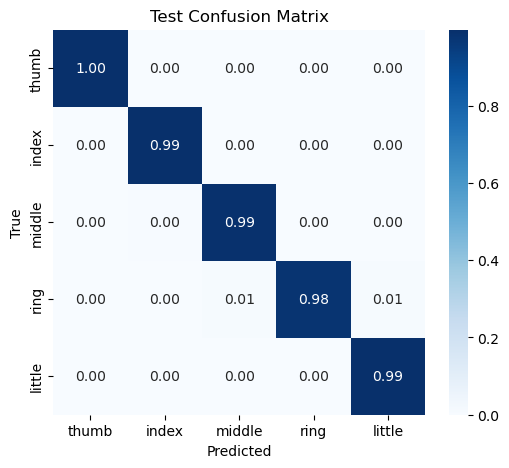

In [7]:
import os
import re
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import (
    Dataset, DataLoader, WeightedRandomSampler, random_split
)
import torchvision.transforms as T
import timm
import kornia
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Configuration
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

DATA_DIRS = [
    os.path.expanduser("~/data/SOCOFing/Real"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Easy"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Medium"),
    os.path.expanduser("~/data/SOCOFing/Altered/Altered-Hard"),
]
BATCH_SIZE     = 32
NUM_WORKERS    = 4
IMG_SIZE       = 224
NUM_CLASSES    = 5   # thumb, index, middle, ring, little
EPOCHS         = 30
LR_HEAD        = 1e-3
LR_BACKBONE    = 1e-5
FREEZE_EPOCHS  = 3
PATIENCE       = 3

FINGER_ORDER = ["thumb", "index", "middle", "ring", "little"]
FINGER_MAP   = {i: name for i, name in enumerate(FINGER_ORDER)}

# 2) Dataset & Transforms
class FingerprintDataset(Dataset):
    def __init__(self, roots, transform=None):
        if isinstance(roots, str):
            roots = [roots]
        self.paths, self.labels = [], []
        exts = {".bmp",".png",".jpg",".jpeg",".tif",".tiff"}
        pat = re.compile(r"(thumb|index|middle|ring|little)", re.IGNORECASE)
        for root in roots:
            if not os.path.isdir(root): continue
            for fn in sorted(os.listdir(root)):
                ext = os.path.splitext(fn)[1].lower()
                if ext in exts:
                    m = pat.search(fn)
                    if m:
                        idx = FINGER_ORDER.index(m.group(1).lower())
                        self.paths.append(os.path.join(root, fn))
                        self.labels.append(idx)
        if not self.paths:
            raise RuntimeError(f"No images found in {roots}")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        arr = np.array(img)
        if self.transform:
            arr = self.transform(arr)
        return arr, self.labels[i]

train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandAugment(num_ops=2, magnitude=9),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_transform = T.Compose([
    T.ToPILImage(),
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# 3) DataLoaders with 70/15/15 split
def make_loaders():
    ds = FingerprintDataset(DATA_DIRS, transform=None)
    n = len(ds)
    n_train = int(0.70 * n)
    n_val   = int(0.15 * n)
    n_test  = n - n_train - n_val
    train_ds, val_ds, test_ds = random_split(ds, [n_train, n_val, n_test])
    train_ds.dataset.transform = train_transform
    val_ds.dataset.transform   = val_transform
    test_ds.dataset.transform  = val_transform

    train_labels = [ds.labels[i] for i in train_ds.indices]
    counts = np.bincount(train_labels, minlength=NUM_CLASSES)
    weights = 1.0 / counts
    sample_w = [weights[l] for l in train_labels]
    sampler = WeightedRandomSampler(sample_w, num_samples=len(sample_w), replacement=True)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                              num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = make_loaders()
print(f"Train: {len(train_loader.dataset)}, Val: {len(val_loader.dataset)}, Test: {len(test_loader.dataset)}")

# 4) Vision Transformer Model
class ViTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_base_patch16_224", pretrained=True,
            num_classes=0, global_pool="avg"
        )
        feat_dim = self.backbone.num_features + 2
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, x):
        f = self.backbone(x)  # [B, F]
        gray = kornia.color.rgb_to_grayscale(x)
        blur = kornia.filters.gaussian_blur2d(gray, (5,5), (1.0,1.0))
        edges= kornia.filters.sobel(blur)
        emap = torch.sqrt((edges**2).sum(dim=1,keepdim=True))
        mv   = emap.view(emap.size(0), -1)
        stats= torch.cat([mv.mean(1,keepdim=True), mv.std(1,keepdim=True)],1)
        return self.head(torch.cat([f, stats], dim=1))

model = ViTModel().to(DEVICE)
for p in model.backbone.parameters(): p.requires_grad = False

# 5) Setup
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
opt_head = optim.AdamW(model.head.parameters(), lr=LR_HEAD)
opt_all  = None
scaler   = torch.amp.GradScaler()
scheduler= optim.lr_scheduler.ReduceLROnPlateau(opt_head, "max", patience=PATIENCE)
best_f1, no_imp = 0.0, 0

# 6) Training loop
for ep in range(1, EPOCHS+1):
    print(f"\nEpoch {ep}/{EPOCHS}")
    if ep == FREEZE_EPOCHS+1:
        for p in model.backbone.parameters(): p.requires_grad = True
        opt_all = optim.AdamW(model.parameters(), lr=LR_BACKBONE)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt_all, "max", patience=PATIENCE)

    model.train()
    tot=corr=0
    opt = opt_head if ep <= FREEZE_EPOCHS else opt_all
    for imgs, labs in train_loader:
        imgs,labs = imgs.to(DEVICE), labs.to(DEVICE)
        opt.zero_grad()
        with torch.amp.autocast(device_type="cuda"):
            outs = model(imgs)
            loss = criterion(outs, labs)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        preds = outs.argmax(1)
        corr += (preds==labs).sum().item(); tot += labs.size(0)
    print(f"  Train Acc: {corr/tot:.4f}")

    # validation
    model.eval()
    y_t,y_p=[],[]
    with torch.no_grad():
        for imgs,labs in val_loader:
            imgs = imgs.to(DEVICE)
            outs = model(imgs)
            preds = outs.argmax(1).cpu().numpy()
            y_p.extend(preds); y_t.extend(labs.cpu().numpy())
    f1  = f1_score(y_t, y_p, average="macro")
    rec = recall_score(y_t, y_p, average="macro")
    print(f"  Val F1: {f1:.4f}, Recall: {rec:.4f}")
    scheduler.step(f1)

    if f1 > best_f1:
        best_f1, no_imp = f1, 0
        torch.save(model.state_dict(), "best_vit.pth")
    else:
        no_imp += 1
        if no_imp > PATIENCE:
            print("Early stopping.")
            break

# 7) Test evaluation
model.load_state_dict(torch.load("best_vit.pth", map_location=DEVICE))
model.eval()
y_t,y_p = [],[]
with torch.no_grad():
    for imgs,labs in test_loader:
        imgs = imgs.to(DEVICE)
        outs = model(imgs)
        preds=outs.argmax(1).cpu().numpy()
        y_p.extend(preds); y_t.extend(labs.cpu().numpy())

acc = accuracy_score(y_t, y_p)
f1  = f1_score(y_t, y_p, average="macro")
rec = recall_score(y_t, y_p, average="macro")
print(f"\nTest Acc: {acc:.4f}, F1: {f1:.4f}, Recall: {rec:.4f}")

# 8) Confusion matrix (test)
cm = confusion_matrix(y_t, y_p)
cmn= cm.astype(float)/cm.sum(axis=1)[:,None]
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt=".2f",
            xticklabels=FINGER_ORDER, yticklabels=FINGER_ORDER,
            cmap="Blues")
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Test Confusion Matrix")
plt.show()

# 9) Real-time viz
def visualize_prediction(path, model, threshold=0.5):
    img = Image.open(path).convert("RGB")
    arr = np.array(img)
    inp = val_transform(arr).unsqueeze(0).to(DEVICE)
    with torch.no_grad(), torch.amp.autocast(device_type="cuda"):
        outs = model(inp)
        probs= torch.softmax(outs,1).cpu().numpy()[0]
    idx  = int(np.argmax(probs)); conf = probs[idx]
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.imshow(arr); plt.title(f"{FINGER_MAP[idx]} ({conf*100:.1f}%)")
    plt.axis("off")
    plt.subplot(1,2,2)
    sns.barplot(x=FINGER_ORDER, y=probs, palette="viridis")
    plt.ylim(0,1); plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return FINGER_MAP[idx], conf

# Usage:
# visualize_prediction("/path/to/test.BMP", model)

/tmp/ipykernel_2315698/2194747505.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=FINGER_ORDER, y=probs, palette="viridis")


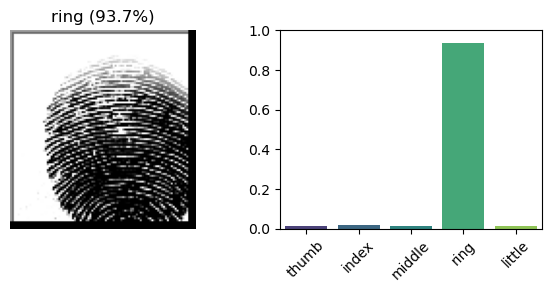

Predicted: ring, Confidence: 93.7%


In [8]:
# 4) Finally call it:
test_path = "/home/zaman-m65/data/SOCOFing/Real/45__M_Right_ring_finger.BMP"
predicted_label, confidence = visualize_prediction(test_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence*100:.1f}%")

/tmp/ipykernel_2315698/2194747505.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=FINGER_ORDER, y=probs, palette="viridis")


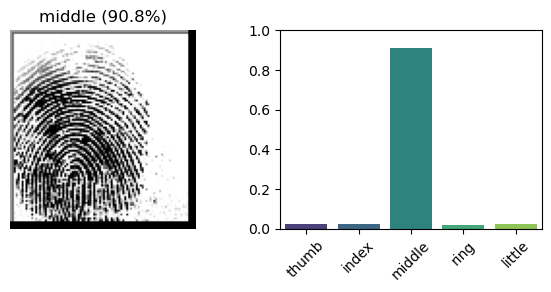

Predicted: middle, Confidence: 90.8%


In [9]:
# 4) Finally call it:
test_path = "/home/zaman-m65/data/SOCOFing/Real/276__M_Left_middle_finger.BMP"
predicted_label, confidence = visualize_prediction(test_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence*100:.1f}%")

/tmp/ipykernel_2315698/2194747505.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=FINGER_ORDER, y=probs, palette="viridis")


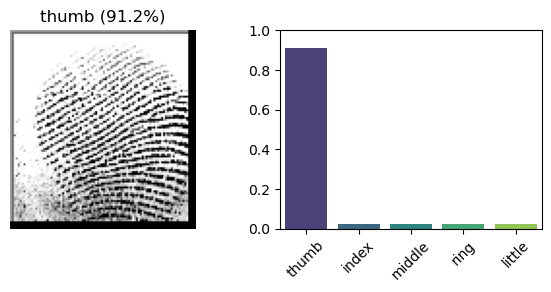

Predicted: thumb, Confidence: 91.2%


In [10]:
# 4) Finally call it:
test_path = "/home/zaman-m65/data/SOCOFing/Real/95__M_Left_thumb_finger.BMP"
predicted_label, confidence = visualize_prediction(test_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence*100:.1f}%")

/tmp/ipykernel_2315698/2194747505.py:242: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=FINGER_ORDER, y=probs, palette="viridis")


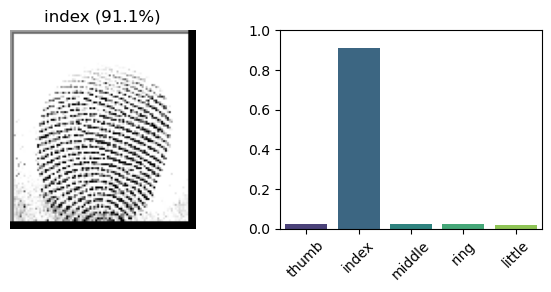

Predicted: index, Confidence: 91.1%


In [11]:
# 4) Finally call it:
test_path = "/home/zaman-m65/data/SOCOFing/Real/95__M_Right_index_finger.BMP"
predicted_label, confidence = visualize_prediction(test_path, model)
print(f"Predicted: {predicted_label}, Confidence: {confidence*100:.1f}%")